## PyTorch

Для выполнения следующего задания понадобится PyTorch. [Инструкция по установке](https://pytorch.org/get-started/locally/)

Если у вас нет GPU, то можно использовать [Google Colab](https://colab.research.google.com/)

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

t = transforms.ToTensor()

cifar_train = datasets.CIFAR10("datasets/cifar10", download=True, train=True, transform=t)
train_loader = DataLoader(cifar_train, batch_size=1024, shuffle=True, pin_memory=torch.cuda.is_available())
cifar_test = datasets.CIFAR10("datasets/cifar10", download=True, train=False, transform=t)
test_loader = DataLoader(cifar_test, batch_size=1024, shuffle=False, pin_memory=torch.cuda.is_available())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Files already downloaded and verified


### Задание 4 (3 балла)
А теперь поработам с настоящими нейронными сетями и настоящими данными. Необходимо реализовать сверточную нейронную сеть, которая будет классифицировать изображения из датасета CIFAR10. Имплементируйте класс `Model` и функцию `calculate_loss`. 

Обратите внимание, что `Model` должна считать в конце `softmax`, т.к. мы решаем задачу классификации. Соответствеено, функция `calculate_loss` считает cross-entropy.

Для успешного выполнения задания необходимо, чтобы `accuracy`, `mean precision` и `mean recall` были больше 0.5

__Можно пользоваться всем содержимым библиотеки PyTorch.__

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=18, kernel_size=3)
        
        self.lin1 = nn.Linear(18*6*6, 60)
        self.lin2 = nn.Linear(60, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = x.flatten(start_dim=1)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = self.relu(x)
        return x
        
def calculate_loss(X: torch.Tensor, y: torch.Tensor, model: Model):
    """
    Cчитает cross-entropy.

    Parameters
    ----------
    X : torch.Tensor
        Данные для обучения.
    y : torch.Tensor
        Метки классов.
    model : Model
        Модель, которую будем обучать.

    """
    
    y_pred = model.forward(X)
    loss = F.cross_entropy(y_pred, y)
    
    return loss

Теперь обучим нашу модель. Для этого используем ранее созданные batch loader'ы.

In [4]:
def train(model, epochs=100):
    optimizer = torch.optim.Adam(model.parameters())
    train_losses = []
    test_losses = []
    for i in range(epochs):
        #Train
        loss_mean = 0
        elements = 0
        for X, y in iter(train_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_mean += loss.item() * len(X)
            elements += len(X)
        train_losses.append(loss_mean / elements)
        #Test
        loss_mean = 0 
        elements = 0
        for X, y in iter(test_loader):
            X = X.to(device)
            y = y.to(device)
            loss = calculate_loss(X, y, model)
            loss_mean += loss.item() * len(X)
            elements += len(X)
        test_losses.append(loss_mean / elements)
        print("Epoch", i, "| Train loss", train_losses[-1], "| Test loss", test_losses[-1])
    return train_losses, test_losses

In [7]:
model = Model().to(device)
train_l, test_l = train(model)

Epoch 0 | Train loss 2.1861439781951906 | Test loss 2.047672246551514
Epoch 1 | Train loss 1.9850886638641358 | Test loss 1.8977589752197266
Epoch 2 | Train loss 1.8062108667373658 | Test loss 1.7374936075210572
Epoch 3 | Train loss 1.6957044927215577 | Test loss 1.6655239995956421
Epoch 4 | Train loss 1.620850944290161 | Test loss 1.5938606548309326
Epoch 5 | Train loss 1.5695207251358032 | Test loss 1.5647115741729736
Epoch 6 | Train loss 1.5265235845184326 | Test loss 1.5054514692306518
Epoch 7 | Train loss 1.4828811248397826 | Test loss 1.4674826391220093
Epoch 8 | Train loss 1.443983384552002 | Test loss 1.4344260284423829
Epoch 9 | Train loss 1.411859539413452 | Test loss 1.4017547651290894
Epoch 10 | Train loss 1.3845478486251832 | Test loss 1.379503638458252
Epoch 11 | Train loss 1.3550876800537108 | Test loss 1.3627880083084107
Epoch 12 | Train loss 1.3331899461746215 | Test loss 1.3394460948944091
Epoch 13 | Train loss 1.3139182941818237 | Test loss 1.3250094007492066
Epoch 1

Построим график функции потерь

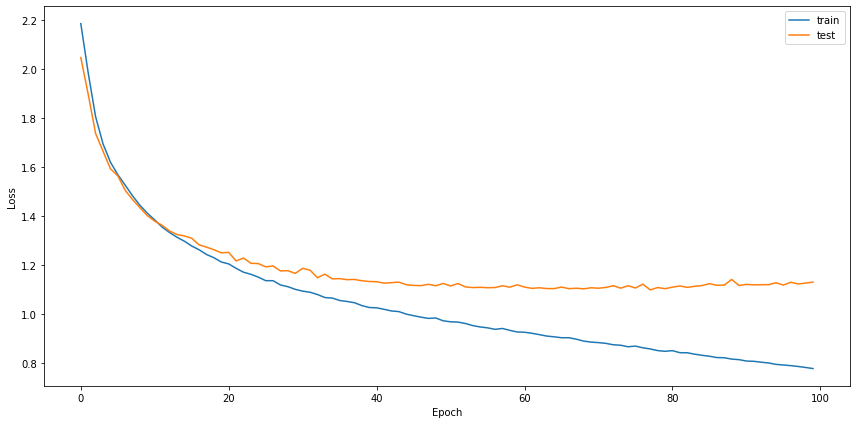

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(train_l)), train_l, label="train")
plt.plot(range(len(test_l)), test_l, label="test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

И, наконец, посчитаем метрики

In [11]:
true_positive = np.zeros(10)
true_negative = np.zeros(10)
false_positive = np.zeros(10)
false_negative = np.zeros(10)
accuracy = 0
ctn = 0
for X, y in iter(test_loader):
    X = X.to(device)
    y = y.to(device)
    with torch.no_grad():
        y_pred = model(X).max(dim=1)[1]
    for i in range(10):
        for pred, real in zip(y_pred, y):
            if real == i:
                if pred == real:
                    true_positive[i] += 1
                else:
                    false_negative[i] += 1
            else:
                if pred == i:
                    false_positive[i] += 1
                else:
                    true_negative[i] += 1
            
    accuracy += torch.sum(y_pred == y).item()
    ctn += len(y)
print("Overall accuracy", accuracy / ctn)
print("Precision", true_positive / (true_positive + false_positive))
print("Recall", true_positive / (true_positive + false_negative))
print("Mean Precision", np.mean(true_positive / (true_positive + false_positive)))
print("Mean Recall", np.mean(true_positive / (true_positive + false_negative)))

Overall accuracy 0.6257
Precision [0.67301906 0.75106383 0.5284738  0.42869955 0.56063618 0.54928018
 0.68600368 0.69441624 0.74603175 0.64417745]
Recall [0.671 0.706 0.464 0.478 0.564 0.496 0.745 0.684 0.752 0.697]
Mean Precision 0.626180172481425
Mean Recall 0.6256999999999999
